# Consumer Reviews of Amazon Products - NLP Assingment

### 1. Project Setup & Introduction

**Project title:** Automated Sentiment Analysis and Key Issue Detection for Amazon Device Reviews

**Stakeholder (who benefits & why):** Amazon Product Managers overseeing product lines like Kindle, Fire TV, Echo, and other Amazon-branded electronics.

**Dataset description & source :**  A list of over 34,000 reviews of Amazon products like the Kindle, Fire TV, etc.

 (https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products)

**Stakeholder's Pain Points**
1.  **Overwhelmed by Review Volume:** Manually sifting through millions of daily customer reviews to understand feedback is impossible, leading to missed insights.
2.  **Lack of Granular Feedback:** Star ratings are insufficient; product managers need to know *what specific aspects* (e.g., battery life, screen quality, software updates, customer support) are driving customer satisfaction or dissatisfaction.
3.  **Slow Identification of Critical Issues:** New bugs, design flaws, or negative trends often go unnoticed until they become widespread, impacting sales and brand reputation.
4.  **Inefficient Resource Allocation:** Without data-driven insights into the most pressing customer concerns, efforts in product development, quality assurance, and customer service may be misdirected.


**Goal of the Project (Solution)**

This project aims to build an end-to-end Natural Language Processing (NLP) pipeline that transforms raw Amazon product reviews into actionable insights. Specifically, it will:
1.  **Automate sentiment classification** (Positive, Negative, Neutral) of customer reviews to provide an overall pulse on product health.
2.  **Identify recurring themes and specific issues** from review text, allowing product managers to pinpoint areas for improvement or highlight successful features.
3.  **Enable proactive monitoring** of customer feedback trends, helping to quickly detect and respond to emerging problems or opportunities.
4.  **Provide a data-driven basis** for prioritizing product development, QA efforts, and customer support strategies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, random
import nltk
nltk.download('punkt'); nltk.download('stopwords'); nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
random.seed(42)
np.random.seed(42)
!pip install gensim
!pip install sentence-transformers
!pip install markovify

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━

# 2. Data Loading & Exploration

Dataset overview, class balance, 3–5 examples per class

In [2]:
pd.set_option("display.max_columns",None)

# Load dataset
df = pd.read_csv("/content/Amazon_product_reviews.csv")

# Inspect
print(df.shape)
df.head(3)

(34660, 21)


/tmp/ipython-input-3774246771.py:4: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/Amazon_product_reviews.csv")


,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",NaN,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ


### Exploratory Data Analysis

In [3]:
df['brand'].value_counts()

,count
brand,
Amazon,28701
Amazon Fire Tv,5056
Amazon Echo,636
Amazon Fire,256
Amazon Digital Services Inc.,10
Amazon Coco T,1


In [4]:
df['categories'].nunique()

41

In [5]:
df['categories'].value_counts()

,count
categories,
"Fire Tablets,Tablets,Computers & Tablets,All Tablets,Electronics, Tech Toys, Movies, Music,Electronics,iPad & Tablets,Android Tablets,Frys",10966
"Stereos,Remote Controls,Amazon Echo,Audio Docks & Mini Speakers,Amazon Echo Accessories,Kitchen & Dining Features,Speaker Systems,Electronics,TVs Entertainment,Clearance,Smart Hubs & Wireless Routers,Featured Brands,Wireless Speakers,Smart Home & Connected Living,Home Security,Kindle Store,Home Automation,Home, Garage & Office,Home,Voice-Enabled Smart Assistants,Virtual Assistant Speakers,Portable Audio & Headphones,Electronics Features,Amazon Device Accessories,iPod, Audio Player Accessories,Home & Furniture Clearance,Consumer Electronics,Smart Home,Surveillance,Home Improvement,Smart Home & Home Automation Devices,Smart Hubs,Home Safety & Security,Voice Assistants,Alarms & Sensors,Amazon Devices,Audio,Holiday Shop",6619
"Back To College,College Electronics,College Tvs & Home Theater,Electronics,Tvs & Home Theater,Streaming Devices,Featured Brands,Amazon Devices,Holiday Shop,Ways To Shop,TV & Home Theater,Streaming Media Players,All Streaming Media Players,TVs Entertainment,Video Games,Kindle Store,Electronics Features,Kids & Family,Fire TV",5056
"Walmart for Business,Office Electronics,Tablets,Office,Electronics,iPad & Tablets,Windows Tablets,All Windows Tablets,Computers & Tablets,E-Readers & Accessories,E-Readers,eBook Readers,Kindle E-readers,Computers/Tablets & Networking,Tablets & eBook Readers,Electronics Features,Books & Magazines,Book Accessories,eReaders,TVs & Electronics,Computers & Laptops,Tablets & eReaders",3176
"Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets",2814
"Tablets,Fire Tablets,Computers & Tablets,All Tablets",1699
"Computers/Tablets & Networking,Tablets & eBook Readers,Computers & Tablets,Tablets,All Tablets",1038
"Featured Brands,Electronics,Amazon Devices,Home,Home Improvement,Home Safety & Security,Home Security,Alarms & Sensors,Smart Home & Home Automation Devices,Mobile,Mobile Speakers,Mobile Bluetooth Speakers,Smart Hubs & Wireless Routers,Smart Hubs,Home, Garage & Office,Smart Home,Voice Assistants,Smart Home & Connected Living,Amazon Tap,Portable Audio,MP3 Accessories,Speakers,Amazon Echo,Electronics Features,TVs & Electronics,Portable Audio & Electronics,MP3 Player Accessories,Home Theater & Audio,Kindle Store,Frys,Electronic Components,Home Automation,Electronics, Tech Toys, Movies, Music,Audio,Bluetooth Speakers",636
"Walmart for Business,Office Electronics,Tablets,Electronics,iPad & Tablets,All Tablets,Computers & Tablets,E-Readers & Accessories,Kindle E-readers,Electronics Features,eBook Readers,See more Amazon Kindle Voyage (Wi-Fi),See more Amazon Kindle Voyage 4GB, Wi-Fi 3G (Unlocked...",580


In [6]:
df['reviews.doRecommend'].value_counts()

,count
reviews.doRecommend,
True,32682
False,1384


In [7]:
df['reviews.rating'].value_counts()

,count
reviews.rating,
5.0,23775
4.0,8541
3.0,1499
1.0,410
2.0,402


**Imbalanced dataset:** It can be seen that majority ratings are positive, hence imbalanced dataset. We have tohave to address this issue.

In [8]:
df['reviews.title'].nunique()

19766

In [9]:
df['reviews.title'].value_counts()

,count
reviews.title,
Great product,645
Great tablet,585
Great,464
Love it,378
Awesome,297
...,...
Really helps in gaming vs using keyboard,1
Grandchildren love it,1
Lacey,1


In [10]:
df['reviews.text'].nunique()

34659

### First Five reviews

In [11]:
for review in df['reviews.text'].head(5):
    print(review)
    print("-" * 100) # Add a separator for clarity

This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.
----------------------------------------------------------------------------------------------------
great for beginner or experienced person. Bought as a gift and she loves it
----------------------------------------------------------------------------------------------------
Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, learn how to Skype on it already...
----------------------------------------------------------------------------------------------------
I've had my Fire HD 8 two weeks now and I love it. This tablet is a great value.We are Prime Members and that is where this tablet SHINES. I love being able to easily access all of the Prime content as well as movies you can download and watch laterThis has a 1280/800 screen which has some really nice look to it its nice and crisp and very bri

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

In [13]:
# List of columns to keep
columns_to_keep = ['brand','categories','reviews.rating','reviews.text','reviews.title']

# Create a new DataFrame with only the selected columns
df_selected = df[columns_to_keep]

df = df_selected

df.head()

,brand,categories,reviews.rating,reviews.text,reviews.title
0,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5.0,This product so far has not disappointed. My c...,Kindle
1,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5.0,great for beginner or experienced person. Boug...,very fast
2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.
3,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!
4,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   brand           34660 non-null  object 
 1   categories      34660 non-null  object 
 2   reviews.rating  34627 non-null  float64
 3   reviews.text    34659 non-null  object 
 4   reviews.title   34654 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.3+ MB


In [15]:
df['reviews.rating'].isnull().sum()

33

In [16]:
df['reviews.rating'].fillna(df['reviews.rating'].mode()[0], inplace=True)

/tmp/ipython-input-577668600.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews.rating'].fillna(df['reviews.rating'].mode()[0], inplace=True)


In [17]:
df['reviews.rating'].isnull().sum()

0

In [18]:
df['reviews.text'].isnull().sum()

1

In [19]:
# Drop rows with missing values in the 'reviews.text' column
df.dropna(subset=['reviews.text'], inplace=True)

# Verify that the missing value has been removed
print("Number of missing values in 'reviews.text' after dropping:", df['reviews.text'].isnull().sum())

Number of missing values in 'reviews.text' after dropping: 0


### Preprocessing Pipeline

(lowercasing, regex, tokenization, stopwords, stemming/lemmatization)

In [20]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Download the punkt_tab resource if not already present
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')


def preprocess_text(text):
    if isinstance(text, str):  # Check if the input is a string
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        return " ".join(tokens)
    else:
        return "" # Return an empty string for non-string values

# Apply
df['clean_reviews.text'] = df['reviews.text'].apply(preprocess_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


**Preprocessed Reviews**

In [21]:
for index, row in df.head(3).iterrows():
    print("\n")
    print("\033[1mOriginal Review:\033[0m")  # \033[1m \033[0m AnSCI code use to make leteers bold
    print(row['reviews.text'])
    print("\n\033[1mPreprocessed Review:\033[0m")
    print(row['clean_reviews.text'])
    print("\n")
    print("-" * 100) # Separator



Original Review:
This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.

Preprocessed Review:
product far disappointed child love use like ability monitor control content see ease


----------------------------------------------------------------------------------------------------


Original Review:
great for beginner or experienced person. Bought as a gift and she loves it

Preprocessed Review:
great beginner experienced person bought gift love


----------------------------------------------------------------------------------------------------


Original Review:
Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, learn how to Skype on it already...

Preprocessed Review:
inexpensive tablet use learn step nabi thrilled learn skype already


----------------------------------------------------------------------------------------------------


### Feature Engineering

Bag of Words, TF-IDF, and Word Embeddings.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words
bow = CountVectorizer(max_features=10000, ngram_range=(1,2))
X_bow = bow.fit_transform(df['clean_reviews.text'])

In [23]:
print("Shape of Bag of Words matrix:", X_bow.shape)

Shape of Bag of Words matrix: (34659, 10000)


In [24]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['clean_reviews.text'])

In [25]:
print("Shape of TF-IDF matrix:", X_tfidf.shape)

Shape of TF-IDF matrix: (34659, 10000)


In [26]:
# Word Embeddings (Gensim Word2Vec)
import gensim.downloader as api

# Load pre-trained Word2Vec (Google News, 300D)
w2v = api.load("word2vec-google-news-300")  # 300-dimensional Word2Vec

def get_w2v_vector(text):
    words = text.split()
    vectors = [w2v[word] for word in words if word in w2v]
    if vectors:  # if at least one word has embedding
        return np.mean(vectors, axis=0)  # average word embeddings
    else:
        return np.zeros(300)  # return zero vector if no valid words

# Apply to all reviews
X_w2v = np.vstack(df['clean_reviews.text'].apply(get_w2v_vector))


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [27]:
print("Shape of Word Embeddings matrix:", X_w2v.shape)
print("\nFirst row of Word Embeddings matrix:")
display(X_w2v[:1])

Shape of Word Embeddings matrix: (34659, 300)

First row of Word Embeddings matrix:


array([[ 0.04983286,  0.03218724,  0.00793457,  0.03812819, -0.10400383,
         0.06380991,  0.16070674, -0.03685115,  0.0865009 ,  0.03277119,
        -0.04861216, -0.13055889,  0.01350109,  0.02285532, -0.1155105 ,
        -0.01758751,  0.05476262,  0.11074594, -0.0187824 , -0.09225699,
         0.0003803 ,  0.04029729,  0.03426889,  0.10181838,  0.09884174,
        -0.05512414, -0.02920063,  0.08337872,  0.03311861, -0.02416992,
        -0.00968111,  0.00250714, -0.09640268, -0.06100347, -0.00396435,
        -0.01351342,  0.01622127, -0.05639648,  0.04824594,  0.07751465,
         0.05430251, -0.01597243,  0.1056096 ,  0.01679406, -0.0881958 ,
        -0.08485765, -0.02866657,  0.03401067,  0.02505728, -0.06607701,
        -0.00637231, -0.001878  , -0.02170974, -0.07920955,  0.04413311,
         0.05470628, -0.0858436 , -0.07047565,  0.08426021, -0.02914546,
         0.01751709,  0.03513747, -0.08894701, -0.00931138, -0.01319768,
         0.0106565 , -0.04856521,  0.12172116, -0.0

### With n-grams

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

bow_ngram = CountVectorizer(
    max_features=10000,       # Keep top 10k features
    ngram_range=(1,3),
)

X_bow_ngram = bow_ngram.fit_transform(df['clean_reviews.text'])
print("Shape:", X_bow_ngram.shape)  # (num_docs, num_features)


Shape: (34659, 10000)


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_ngram = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,3),
)

X_tfidf_ngram = tfidf_ngram.fit_transform(df['clean_reviews.text'])
print("Shape:", X_tfidf_ngram.shape)


Shape: (34659, 10000)


In [30]:
feature_names = bow_ngram.get_feature_names_out()
sum_words = X_bow_ngram.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in bow_ngram.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
print(words_freq[:20])  # Top 20 n-grams


[('great', 11737), ('tablet', 9950), ('love', 9227), ('use', 7604), ('easy', 6140), ('amazon', 5855), ('kindle', 5325), ('one', 5134), ('bought', 5048), ('good', 5000), ('fire', 4883), ('work', 4243), ('price', 4201), ('like', 4129), ('product', 3932), ('tv', 3346), ('get', 3280), ('book', 3201), ('would', 3192), ('kid', 3112)]


###  Modeling & Evaluation

(Naive Bayes = generative, Logistic Regression = discriminative).


### Key Points
**MultinomialNB** →  works only with count-based features (BoW, TF‑IDF). It won’t work with Word2Vec (because W2V can have negative values and is continuous).

**Logistic Regression & Linear SVM** → work with all types of features (BoW, TF‑IDF, W2V).

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Assuming your target column is 'label'
y = df['reviews.rating']


# Train-test split (use same split for fair comparison)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_bow_ngram, X_test_bow_ngram, _, _ = train_test_split(X_bow_ngram, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_tfidf_ngram, X_test_tfidf_ngram, _, _ = train_test_split(X_tfidf_ngram, y, test_size=0.2, random_state=42)
X_train_w2v, X_test_w2v, _, _ = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

# Function to train & evaluate a model
def train_and_evaluate(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} - Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

# 1. Multinomial Naive Bayes (only for BoW/TF-IDF)
print("=== MultinomialNB ===")
train_and_evaluate(MultinomialNB(), X_train_bow, X_test_bow, y_train, y_test, "BoW")
train_and_evaluate(MultinomialNB(), X_train_tfidf, X_test_tfidf, y_train, y_test, "TF-IDF")

# 2. Logistic Regression (for all features)
print("=== Logistic Regression ===")
lr = LogisticRegression(max_iter=1000)
train_and_evaluate(lr, X_train_bow_ngram, X_test_bow_ngram, y_train, y_test, "BoW + N-gram")
train_and_evaluate(lr, X_train_tfidf_ngram, X_test_tfidf_ngram, y_train, y_test, "TF-IDF + N-gram")
train_and_evaluate(lr, X_train_w2v, X_test_w2v, y_train, y_test, "Word2Vec")

# 3. Linear SVM
print("=== Linear SVM ===")
svm = LinearSVC()
train_and_evaluate(svm, X_train_tfidf_ngram, X_test_tfidf_ngram, y_train, y_test, "TF-IDF + N-gram")
train_and_evaluate(svm, X_train_w2v, X_test_w2v, y_train, y_test, "Word2Vec")

=== MultinomialNB ===

BoW - Accuracy: 0.6771
              precision    recall  f1-score   support

         1.0       0.39      0.23      0.29        81
         2.0       0.25      0.01      0.02        84
         3.0       0.27      0.25      0.26       321
         4.0       0.43      0.42      0.43      1732
         5.0       0.79      0.82      0.81      4714

    accuracy                           0.68      6932
   macro avg       0.43      0.35      0.36      6932
weighted avg       0.67      0.68      0.67      6932


TF-IDF - Accuracy: 0.6995
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        81
         2.0       0.00      0.00      0.00        84
         3.0       0.00      0.00      0.00       321
         4.0       0.48      0.16      0.24      1732
         5.0       0.72      0.97      0.83      4714

    accuracy                           0.70      6932
   macro avg       0.24      0.23      0.21      6932
weig

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



BoW + N-gram - Accuracy: 0.6733
              precision    recall  f1-score   support

         1.0       0.53      0.26      0.35        81
         2.0       0.19      0.07      0.10        84
         3.0       0.30      0.18      0.23       321
         4.0       0.41      0.31      0.35      1732
         5.0       0.76      0.86      0.80      4714

    accuracy                           0.67      6932
   macro avg       0.44      0.34      0.37      6932
weighted avg       0.64      0.67      0.65      6932


TF-IDF + N-gram - Accuracy: 0.7067
              precision    recall  f1-score   support

         1.0       0.62      0.06      0.11        81
         2.0       0.00      0.00      0.00        84
         3.0       0.41      0.09      0.14       321
         4.0       0.49      0.27      0.34      1732
         5.0       0.74      0.93      0.83      4714

    accuracy                           0.71      6932
   macro avg       0.45      0.27      0.29      6932
weighted

In [32]:
from sklearn.metrics import f1_score
import pandas as pd

# Collect results
models = [
    ("MultinomialNB (BoW)", MultinomialNB(), X_train_bow, X_test_bow),
    ("MultinomialNB (TF-IDF)", MultinomialNB(), X_train_tfidf, X_test_tfidf),
    ("LogReg (BoW+N-gram)", LogisticRegression(max_iter=1000), X_train_bow_ngram, X_test_bow_ngram),
    ("LogReg (TF-IDF+N-gram)", LogisticRegression(max_iter=1000), X_train_tfidf_ngram, X_test_tfidf_ngram),
    ("LogReg (Word2Vec)", LogisticRegression(max_iter=1000), X_train_w2v, X_test_w2v),
    ("LinearSVM (TF-IDF+N-gram)", LinearSVC(), X_train_tfidf_ngram, X_test_tfidf_ngram),
    ("LinearSVM (Word2Vec)", LinearSVC(), X_train_w2v, X_test_w2v)
]

results = []
for name, model, X_train, X_test in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    results.append([name, acc, f1_macro, f1_weighted])

# Create DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1-Macro", "F1-Weighted"])
print("\n=== Model Performance Table ===")
print(results_df)



=== Model Performance Table ===
                       Model  Accuracy  F1-Macro  F1-Weighted
0        MultinomialNB (BoW)  0.677149  0.361591     0.669784
1     MultinomialNB (TF-IDF)  0.699510  0.212673     0.621269
2        LogReg (BoW+N-gram)  0.673254  0.367429     0.650510
3     LogReg (TF-IDF+N-gram)  0.706722  0.285797     0.657706
4          LogReg (Word2Vec)  0.694605  0.250599     0.622836
5  LinearSVM (TF-IDF+N-gram)  0.683930  0.334841     0.652614
6       LinearSVM (Word2Vec)  0.693306  0.227009     0.612098


### Sentence Transformer (BERT) embeddings

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
from sentence_transformers import SentenceTransformer

# === 1. Create Sentence-BERT Embeddings ===
print("Generating Sentence-BERT embeddings...")
bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast, good for classification

# Reset the index of the DataFrame before encoding
df_reset = df.reset_index(drop=True)
X_bert = bert_model.encode(df_reset['clean_reviews.text'], convert_to_numpy=True)

# Target
y = df_reset['reviews.rating']


# Train-test split
X_train_bert, X_test_bert, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

# === 2. Models to Train ===
models = [
    ("Logistic Regression (BERT)", LogisticRegression(max_iter=1000, class_weight='balanced')),
    ("Linear SVM (BERT)", LinearSVC(class_weight='balanced'))
]

# === 3. Train & Evaluate Models ===
results = []
for name, model in models:
    model.fit(X_train_bert, y_train)
    y_pred = model.predict(X_test_bert)
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    results.append([name, acc, f1_macro, f1_weighted])

# === 4. Show Results in Table ===
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1-Macro", "F1-Weighted"])
print("\n=== Sentence-BERT Model Performance ===")
print(results_df)

Generating Sentence-BERT embeddings...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



=== Sentence-BERT Model Performance ===
                        Model  Accuracy  F1-Macro  F1-Weighted
0  Logistic Regression (BERT)  0.507790  0.285370     0.561223
1           Linear SVM (BERT)  0.611079  0.293048     0.609693


### Markov Chain Text Generation

In [34]:
import markovify

# Combine all cleaned reviews into a single string
text_for_markov = " ".join(df['clean_reviews.text'].tolist())

# Build the Markov chain model
# state_size=2 means the model will consider the preceding two words
text_model = markovify.Text(text_for_markov, state_size=2)

print("Markov Chain model built successfully!")

Markov Chain model built successfully!


In [35]:
# Generate some sentences
print("Generated sentences:")
for i in range(5): # Generate 5 sentences
    sentence = text_model.make_sentence()
    if sentence: # make_sentence might return None if it can't generate a valid sentence
        print(f"- {sentence}")
    else:
        print("- Could not generate a sentence.")

Generated sentences:
- Could not generate a sentence.
- product far couldnt happier echo better integration skill ever expanding content recommend getting case little clumsy overall good purchase basic usage nice tablet couldnt made better choice mention cheapest four brand pick well set living room love able download book amazon make money selling content lockeddown store android app store others bad also give month free subscription amazon free time application set dont care losing get work love watch whatever want come warranty anything break replaced free final selling point free year amazon increase atleast 1 year contacted amazon fairly brief support chat new kindle paperwhite best kindle come backlight great nightime excellent product price fare happy kindle fire uhd monitor interface really nice feature price looking back definitely would recommend anyone looking tablet use check mail facebook googlepay bill process fast beautiful picture samsung tv work great needed wish volum

### Mapping Rating to Sentiment

In [36]:
# MAP RATINGS TO SENTIMENT
# ============================
# Convert ratings (1-5) into sentiment labels
def rating_to_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['reviews.rating'].apply(rating_to_sentiment)

In [37]:
X_tfidf_ngram = tfidf_ngram.fit_transform(df['clean_reviews.text'])
y = df['sentiment']

# Split into train & test
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf_ngram, y, test_size=0.2, random_state=42, stratify=y
)

# ============================
#  TRAIN LOGISTIC REGRESSION
# ============================
lr = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight handles imbalance
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)


In [38]:
# ============================
#  EVALUATE MODEL
# ============================
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


=== Classification Report ===
              precision    recall  f1-score   support

    negative       0.25      0.50      0.33       162
     neutral       0.16      0.39      0.22       300
    positive       0.97      0.88      0.92      6470

    accuracy                           0.85      6932
   macro avg       0.46      0.59      0.49      6932
weighted avg       0.92      0.85      0.88      6932

Accuracy: 0.85


In [39]:
# Add predictions back to df
df['predicted_sentiment'] = lr.predict(X_tfidf_ngram)

### Overall Customer Sentiment : Are customers happy or not?

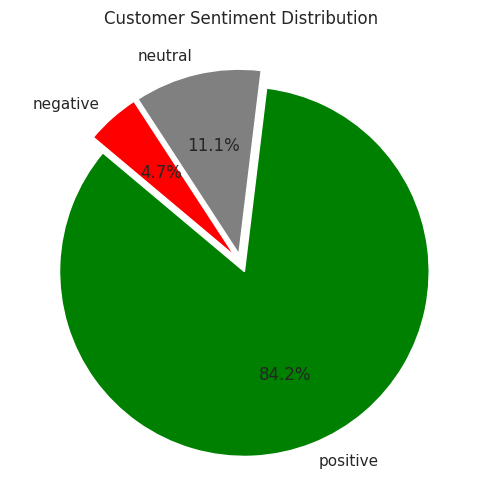

In [43]:
# Pie chart for sentiment distribution
sentiment_counts = df['predicted_sentiment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=['green','gray','red'],
    startangle=140,
    explode=[0.05,0.05,0.05]
)
plt.title("Customer Sentiment Distribution")
plt.show()


**Overall Customer Sentiment:**

**84.2% Customer are happy which is good indicator but there is an opportunity to improve rest 15.8%**

### Aspect vs Sentiment Proportion

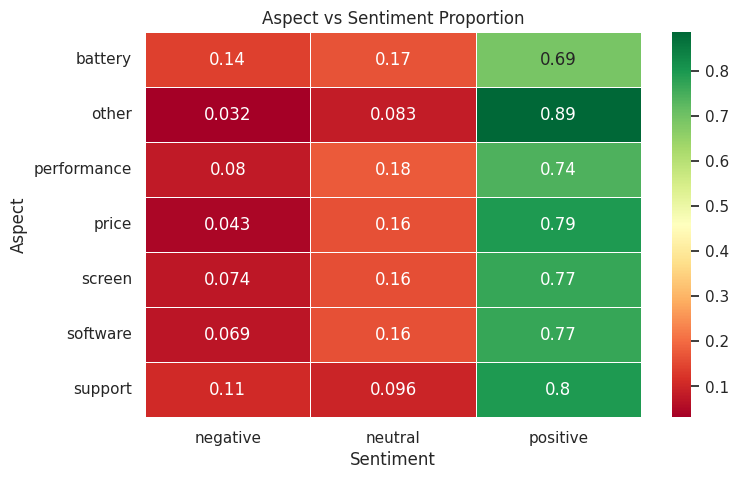

In [44]:
# Create aspect vs sentiment matrix
aspect_sentiment = []
for _, row in df.iterrows():
    for aspect in row['aspects']:
        aspect_sentiment.append((aspect, row['predicted_sentiment']))

aspect_df = pd.DataFrame(aspect_sentiment, columns=['aspect','sentiment'])
heatmap_data = aspect_df.groupby(['aspect','sentiment']).size().unstack().fillna(0)

# Normalize by row to get proportions
heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(8,5))
sns.heatmap(heatmap_data, annot=True, cmap="RdYlGn", linewidths=.5)
plt.title("Aspect vs Sentiment Proportion")
plt.ylabel("Aspect")
plt.xlabel("Sentiment")
plt.show()


**Actionable Information for Stakeholders:**

It highlights which aspects needs most attention.

**Rows** = Aspects (e.g., battery, screen, software) → what customers are talking about

**Columns** = Sentiments (positive, neutral, negative) → how customers feel about each aspect

**Cells** = Proportion of reviews for that aspect with that sentiment (0 to 1).

Example: If the battery row has 0.70 under negative, it means 70% of all battery-related mentions are negative.

### Sentiment Trend over time

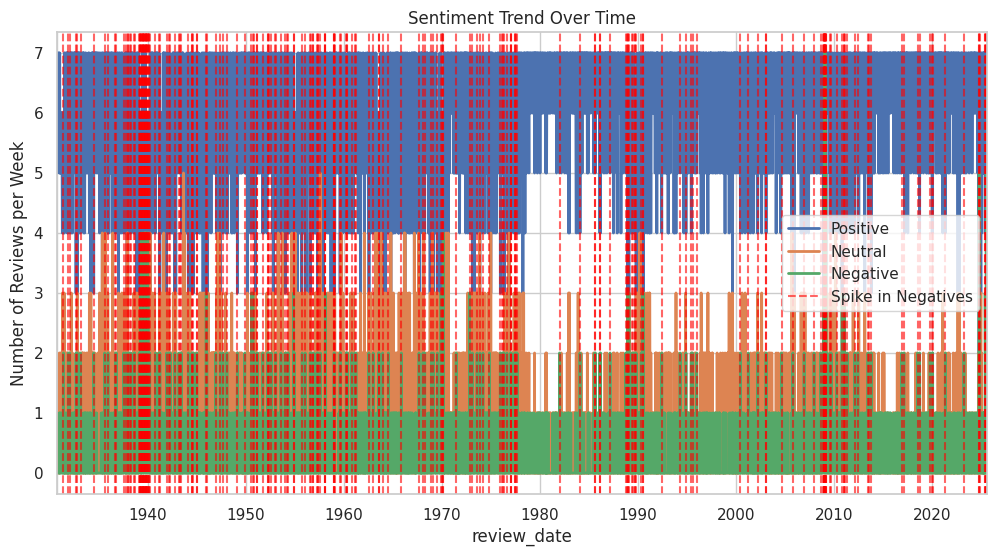

In [45]:
# Sentiment trend
trend[['positive','neutral','negative']].plot(figsize=(12,6), linewidth=2)
plt.title("Sentiment Trend Over Time")
plt.ylabel("Number of Reviews per Week")

# Highlight alert points (spikes in negative reviews)
for date in alerts.index:
    plt.axvline(x=date.start_time, color='red', linestyle='--', alpha=0.6)
plt.legend(["Positive","Neutral","Negative","Spike in Negatives"])
plt.show()


**Actionable inside for Stakeholders:**

**Product managers instantly see when negative reviews spiked and need investigation.**

### Word Cloud for Positive and Negative Reviews

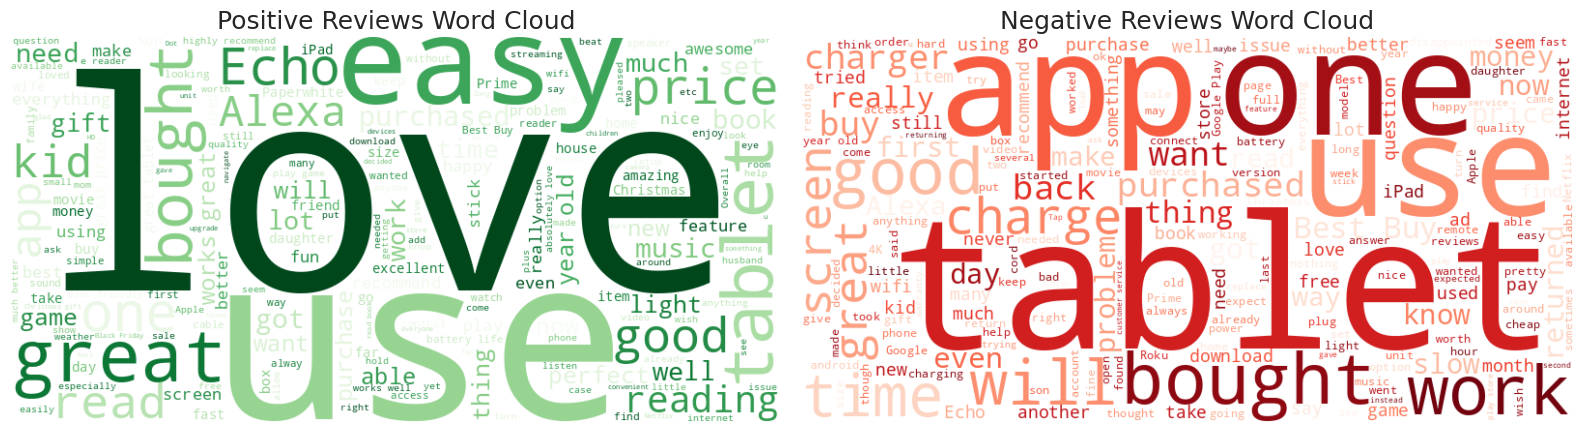

In [47]:
# ============================
# WORD CLOUDS FOR POSITIVE & NEGATIVE REVIEWS
# ============================
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Separate positive and negative reviews
positive_text = " ".join(df[df['predicted_sentiment']=='positive']['reviews.text'].astype(str))
negative_text = " ".join(df[df['predicted_sentiment']=='negative']['reviews.text'].astype(str))

# Define stopwords (remove common meaningless words)
stopwords = set(STOPWORDS)
stopwords.update(["amazon","product","device","kindle","fire","tv","review"])  # add domain-specific stopwords

# Generate positive word cloud
wc_positive = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords, colormap='Greens').generate(positive_text)

# Generate negative word cloud
wc_negative = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords, colormap='Reds').generate(negative_text)

# Plot both word clouds side by side
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(wc_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews Word Cloud", fontsize=18)

plt.subplot(1,2,2)
plt.imshow(wc_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews Word Cloud", fontsize=18)

plt.tight_layout()
plt.show()

**Generates WordClouds:**

**Positive** in green (happier tone).

**Negative** in red (problem indicators).

Displays side-by-side for easy comparison.

**Actionable information for Stakeholders:**

**Positive WordCloud** → Shows words customers love (e.g., "easy", "quality", "screen").

**Negative WordCloud** → Highlights pain points (e.g., "battery", "slow", "charging").

### Severity Scoring and Alerts


=== ALERTS: High Severity Spikes Detected ===
review_date
1931-05-18/1931-05-24    1.142857
1932-05-09/1932-05-15    0.857143
1932-09-05/1932-09-11    1.000000
1932-09-26/1932-10-02    1.285714
1932-10-10/1932-10-16    1.142857
                           ...   
2024-11-04/2024-11-10    1.142857
2024-11-11/2024-11-17    1.571429
2024-11-25/2024-12-01    1.000000
2024-12-02/2024-12-08    1.571429
2025-01-27/2025-02-02    1.285714
Freq: W-SUN, Name: severity_score, Length: 164, dtype: float64


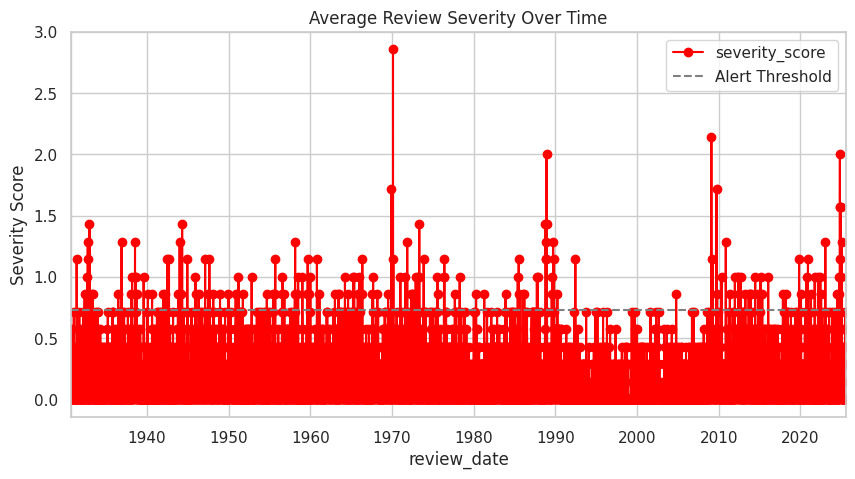


=== HIGH-SEVERITY REVIEWS ===
                                          reviews.text predicted_sentiment  \
52   I purchased the kindle fire because I needed a...            positive   
75   A family member has vision problems. They had ...            positive   
117  Didn't have some of the features I was looking...            negative   
126  i Bought this around black friday for $60 hopi...            negative   
255  I bought this tablet to be pretty much exclusi...             neutral   
257  I originally purchased a Kindle paperwhite but...            positive   
310  I liked it at first except the browser is kind...            negative   
332  I bought this as a temporary replacement for m...            positive   
372  This was a reasonable replacement for a broken...            positive   
395  This is a nice little tablet for the $60 I pai...             neutral   

    severity_level                review_date  
52            High 1930-10-31 17:36:45.212272  
75            

In [48]:
# ============================
# 1.DEFINE SEVERITY KEYWORDS
# ============================
severity_keywords = {
    "high": ["not working", "broken", "stopped working", "doesn't turn on", "refund", "return", "dead", "defective", "overheating"],
    "medium": ["slow", "crash", "freeze", "lag", "poor", "issue", "problem", "charging issue", "setup problem"],
    "low": ["scratches", "cheap", "difficult", "average", "noisy", "uncomfortable"]
}

# ============================
# 2. FUNCTION TO SCORE SEVERITY
# ============================
def score_severity(text):
    text_lower = str(text).lower()
    score = 0
    if any(word in text_lower for word in severity_keywords["high"]):
        score += 3
    if any(word in text_lower for word in severity_keywords["medium"]):
        score += 2
    if any(word in text_lower for word in severity_keywords["low"]):
        score += 1
    return score

df['severity_score'] = df['reviews.text'].apply(score_severity)

# Tagging severity levels
def label_severity(score):
    if score >= 3:
        return "High"
    elif score == 2:
        return "Medium"
    elif score == 1:
        return "Low"
    else:
        return "None"

df['severity_level'] = df['severity_score'].apply(label_severity)

# ============================
# 3. WEEKLY AGGREGATION
# ============================
df['review_date'] = pd.to_datetime(df.get('review_date', pd.date_range(end=pd.Timestamp.today(), periods=len(df))))
weekly_severity = df.groupby(df['review_date'].dt.to_period('W'))['severity_score'].mean()

# Detect spike (alerts)
threshold = weekly_severity.mean() + 2 * weekly_severity.std()
alerts = weekly_severity[weekly_severity > threshold]
print("\n=== ALERTS: High Severity Spikes Detected ===")
print(alerts)

# ============================
# 4. VISUALIZE SEVERITY TREND
# ============================
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
weekly_severity.plot(kind='line', marker='o', color='red')
plt.axhline(y=threshold, color='gray', linestyle='--', label='Alert Threshold')
plt.title("Average Review Severity Over Time")
plt.ylabel("Severity Score")
plt.legend()
plt.show()

# ============================
# 5. HIGH-SEVERITY REVIEWS REPORT
# ============================
high_severity_reviews = df[df['severity_level']=="High"][['reviews.text','predicted_sentiment','severity_level','review_date']]
print("\n=== HIGH-SEVERITY REVIEWS ===")
print(high_severity_reviews.head(10))

**It inform stakeholders where most attention is needed based on reviews severity**

**Each review is scored:**

**High** = device not working, refund requested, major failure.

**Medium** = performance issues, crashes, etc.

**Low** = minor complaints.



**Weekly severity monitoring:**
 Detects spikes in critical complaints.


**High-severity review list:** Quick list of the most urgent reviews (for investigation)
